# Hungry AI Project - UO CS 472 ML
#### This project explores how well a text-to-image GAN can produce or "imagine" images for text phrases its never been trained for. To do this, we use a pretrained "Spacially Semantic Aware GAN" or SSAGAN, and... (finish later)

## 0. Setup Basic stuff like Imports, Device, etc

In [2]:
#Imports copied from text2image-alder "main.py"
from __future__ import print_function
import multiprocessing

import os
import io
import sys
import time
import errno
import random
import pprint
import datetime
import dateutil.tz
import argparse

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from miscc.utils import mkdir_p
from miscc.utils import imagenet_deprocess_batch
from miscc.config import cfg, cfg_from_file
from miscc.losses import DAMSM_loss
from sync_batchnorm import DataParallelWithCallback
#from datasets_everycap import TextDataset
from datasets import TextDataset
from datasets import prepare_data
from DAMSM import RNN_ENCODER, CNN_ENCODER
from model import NetG, NetD

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Generate Images from GAN

In [3]:
import main
import datasets
from miscc.config import cfg, cfg_from_file
# Prepare dataset to get wordtoix

cfg_file_path = "cfg/food.yml"
cfg_from_file(cfg_file_path)
imsize = cfg.TREE.BASE_SIZE
batch_size = cfg.TRAIN.BATCH_SIZE
image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])

# Use my own values instead of the ones in cfg
#data_dir = "C:/Users/Alder/Desktop/school/cs472/cs472_hw1/CUB_200_2011/"
data_dir = "C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/"
dataset = TextDataset(data_dir, 'train',
                              base_size=cfg.TREE.BASE_SIZE,
                              transform=image_transform)

wordtoix = dataset.wordtoix 




Load filenames from: C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data//train/filenames.pickle (2100)
Load filenames from: C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data//test/filenames.pickle (2100)
Load from:  C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/captions.pickle


### A. Generate Images from Model with CUB Dataset
I need to figure out how to generate images using the CUB dataset to see how this code works.

In [4]:
# Load pretrained: SSAGAN model, encoder, 
from model import NetG, NetD

# Need to load GAN as NetG model in "models.py"
# ssagan_path = "C:/Users/Alder/Desktop/HungryAI/SSAGAN_models/finetune/cub/netG_550.pth"
ssagan_path = "tmp/food_sloss01/64/models/netG_300.pth" # ALSO UPDATE IN .yml 'NetG'!
netG = NetG(cfg.TRAIN.NF, 100).to(device)
netG = DataParallelWithCallback(netG)
netG.load_state_dict(torch.load(ssagan_path))
netG.eval()


# Need to load text_encoder in a similar manner
text_encoder = RNN_ENCODER(dataset.n_words, nhidden=cfg.TEXT.EMBEDDING_DIM) # was dataset.nwords before 58
state_dict = torch.load(cfg.TEXT.DAMSM_NAME, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
text_encoder.cuda()
text_encoder.eval()


c:\Users\Alder\.conda\envs\PyTorchEnv\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNN_ENCODER(
  (encoder): Embedding(883, 300)
  (drop): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
)

In [5]:
main.gen_sample(text_encoder, netG, device, wordtoix)

Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/valid/img_0.png
Saving generated fusion mask to: tmp/food_sloss01/64/models/netG_300/valid/fm_0.png
Saving generated image

#### Analysis of Generated Images from CUB dataset
I generated some images from the fully pretrained model as well a model I ran for only 6 epochs.
The images from the fully pretrained model looked great, and the one I ran for only 6 epochs looked like a bird image but swirled. 

### B. Generate Images from Own Dataset 
To do this, I will need to make my own foods dataset's structure match that of the CUB dataset. I will also need to make my own "Preprocessed metadata" since that is used by the SSAGAN. 

#### i. Investigate the contents of the metadata from the SSAGAN google drive that I put in the CUB dataset.

In [6]:
import pickle
import os
import pprint
import numpy as np

cub_path = "C:/Users/Alder/Desktop/school/cs472/cs472_hw1/CUB_200_2011/"


train_class_info_path = os.path.join(cub_path, "train/class_info.pickle")
test_class_info_path = os.path.join(cub_path, "test/class_info.pickle")
train_class_info = pickle.load(
   open(train_class_info_path, "rb"), encoding='latin1')
test_class_info = pickle.load(
   open(test_class_info_path, "rb"), encoding='latin1')

train_filenames_path = os.path.join(cub_path, "train/filenames.pickle")
test_filenames_path = os.path.join(cub_path, "test/filenames.pickle")
train_filenames = pickle.load(
   open(train_filenames_path, "rb"), encoding='latin1')
test_filenames = pickle.load(
   open(test_filenames_path, "rb"), encoding='latin1')

#captions = pickle.load( # captions is too large too load and print
 #  open("./birds/captions.pickle", "rb"), encoding='latin1')


print("Notice how the train and test class info is never the same at the same position,\
      this is how the sets are split.")
      
print(train_class_info[0:10])
print(test_class_info[0:10])

print(train_filenames[0:10])
print(test_filenames[0:10])

print("I should be able to copy this format for my own foods dataset.")


Notice how the train and test class info is never the same at the same position,      this is how the sets are split.
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['002.Laysan_Albatross/Laysan_Albatross_0002_1027', '002.Laysan_Albatross/Laysan_Albatross_0003_1033', '002.Laysan_Albatross/Laysan_Albatross_0082_524', '002.Laysan_Albatross/Laysan_Albatross_0044_784', '002.Laysan_Albatross/Laysan_Albatross_0070_788', '002.Laysan_Albatross/Laysan_Albatross_0050_870', '002.Laysan_Albatross/Laysan_Albatross_0071_792', '002.Laysan_Albatross/Laysan_Albatross_0053_543', '002.Laysan_Albatross/Laysan_Albatross_0081_800', '002.Laysan_Albatross/Laysan_Albatross_0001_545']
['001.Black_footed_Albatross/Black_Footed_Albatross_0046_18', '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34', '001.Black_footed_Albatross/Black_Footed_Albatross_0002_55', '001.Black_footed_Albatross/Black_Footed_Albatross_0074_59', '001.Black_footed_Albatross/Black_Footed_Albatross_0014_89', '001.Black_

#### SSAGAN CUB metadata analysis
Given index "i" looks like the "class_info.pickle" files contains a list of ints whose "i"th positions are the class ints for the "i"th filenames listed in "filenames.pickle". Notice both of these pickle files contained pickled python lists, so my goal is to create pickled python lists of my file names and their repective class ints. 

**ALSO**: I inspected the code in "datasets.py" and "main.py", and it looks like the "captions.pickle" file is created from the class_info and filenames pickle files, as well as the 10 captions per image found in "/text/". So I will also need to make a folder of folders of image captions for each of my images.

#### ii. Create Metadata for own dataset

First, make the test/ and train/ filenames and class_info pickle files.

In [7]:
import os
# Copied and pasted this from:
# https://stackoverflow.com/questions/19932130/iterate-through-folders-then-subfolders-and-print-filenames-with-path-to-text-f
def list_files(dir):
    filenames = []
    class_info = []
    class_index = -1 # was -1, but maybe I'm off by one?
    for root, dirs, files in os.walk(dir):
        class_index += 1
        for name in files:
            if ".jpg" in name:
            #r.append(os.path.join(root, name))
                filenames.append(root + "/" + name)
                class_info.append(class_index)
    return filenames, class_info

In [8]:
path_to_food_data = "C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/"
filenames, class_info = list_files(path_to_food_data)
print(filenames[0:5])
print(class_info[0:5])
print(filenames[200])
print(class_info[200])
print(filenames[-1])
print(class_info[-1])



['C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 0.jpg', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 1.jpg', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 10.jpg', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 11.jpg', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 12.jpg']
[1, 1, 1, 1, 1]
C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/003.Chicken/Chicken 0.jpg
3
C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/021.Waffles/Waffles 99.jpg
21


It looks like I have a class_info and filenames set, now I need to split them into their train and test counterparts. I will use 1/5 of the photos for testing, and the rest for training. 

**ACTUALLY** After further inspection, it looks like the train/test sets are divided by classes. I.e. bird species that are in the test set are never in the train set and vice versa. This makes sense because when the GAN is tested, it is supposed to be tested on how well it generates images of the birds that its never "seen" (been trained for) before based off their captions. HOWEVER, I want to use ALL of the images I have to train the GAN, and I don't really care about testing it because I want to see how well it can produce images of the combo foods based off their descriptions. 

So if I want to make a "real" test set at some point, I should use the "combo food" images, but at this point I don't really care about that, so I will simply use the same "filenames" and "class_info" data for both the train and test folders. 

In [9]:
# ITS PICKLIN TIME!!!
# Create the "class_info" and "filenames" pickle files in "train/" and "test/" 
# directories of my single foods dataset
path_to_food_folder = "C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/"
train_path = path_to_food_folder + "train/"
test_path = path_to_food_folder + "test/"
train_filenames_path = train_path + "filenames.pickle"
train_class_info_path = train_path + "class_info.pickle"
test_filenames_path = test_path + "filenames.pickle"
test_class_info_path = test_path + "class_info.pickle"


with open(train_filenames_path, 'wb') as f:
                pickle.dump(filenames, f, protocol=0)

with open(train_class_info_path, 'wb') as f:
                pickle.dump(class_info, f, protocol=0)



with open(test_filenames_path, 'wb') as f:
                pickle.dump(filenames, f, protocol=0)

with open(test_class_info_path, 'wb') as f:
                pickle.dump(class_info, f, protocol=0)


Second, make a "text/" folder of folders with 10 captions per image for your dataset

To do this, I copy and paste all the food descriptions into one massive text file. There should be one caption per line, with exactly 25 captions per class. I can iterate through this list, and randomly select 10 captions from the set of 25, and writes the 10 captions to a .txt file with the same file name as an image, in a directory structure that mimics the CUB images directory's.

In [14]:
# NOTE: I don't see why I can't put the .txt files in the same directory as
# the image files. I will probably have to change something in main.py down the road,
# but I think that will be easier than trying to drastically change each .txt filename here
test_txt_filename = filenames[0][:-3]
print(test_txt_filename)
txt_filenames = []
for name in filenames:
    txt_filename = name[:-3] + "txt"
    txt_filenames.append(txt_filename)
print(txt_filenames[0:5])

captions_file_path = "C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/single_food_captions.txt"
captions_file = open(captions_file_path, "r") # .txt file with all the captions (25 per class)
captions = []
for line in captions_file:
    line = line.strip(" .-,")
    captions.append(line.lower())
captions_file.close()
print(f"The length of the captions array is: {len(captions)} ")

random_cap_indices = [] # this will help us randomly select 10 of our 25 captions
# for each txt file so it has shape (len(filenames), 10)
for i in range(0, len(txt_filenames)):
    rand_list = []
    for k in range(0, 10):
        rand_list.append(random.randrange(25))
    random_cap_indices.append(rand_list)
    if(len(rand_list) < 10):
        print("ERROR: The list of random number is < 10 so < 10 captions!")

i = 0
food_class = 0
for txt_filename in txt_filenames:
    class_tracker = food_class * 25 # helps us index into write part of captions list
    # since there are 25 captions per class
    #NOTE: I think open below is causing the <10 captions issue.
    with open(txt_filename, "w", newline='\n') as f: 
        for j in range(0,10): # was: for rand_num in random_cap_indices[i]:
            rand_num = random_cap_indices[i][j]
            f.write(captions[rand_num + class_tracker])
        i += 1
    if i % 100 == 0:
        food_class += 1

print("The text folder with the .txt captions file for each image should be ready...")

C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 0.
['C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 0.txt', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 1.txt', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 10.txt', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 11.txt', 'C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/gpt_single_foods/001.Beans/Beans 12.txt']
The length of the captions array is: 525 
The text folder with the .txt captions file for each image should be ready...


#### iii. Fine-Tune GAN with my single food images and metadata

In [ ]:
#!Powershell.exe -Command "conda activate PyTorchEnv"
#!Powershell.exe -Command "python main.py --cfg cfg/food.yml --gpu 0 --data_dir C:/Users/Alder/Desktop/HungryAI/cs472_proj/scraped_data/ --manualSeed 666 "

Traceback (most recent call last):
  File "C:\Users\Alder\Desktop\HungryAI\text2image-alder\main.py", line 24, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


#### iv. Generate Images of Combo Foods with single foods trained GAN

To do this I will copy and modify the SSAGAN's "gen_sample()" to "gen_sample_alder()" function to take one caption at a time, and use that caption to generate 4 images. That way we can use the 25 captions I generated with chatGPT for each combo class to generate 100 images per combo class.

In [6]:
import main

class_label = "grilled cheese and tomato soup"
caption = "the grilled cheese is warm and cheesy paired with a classic tomato soup"
main.gen_sample_alder(text_encoder, netG, device, wordtoix, caption, class_label, 0)

Encountered key error with key: paired
Replacing that key with 'and' and continuing...
TEST: I think batch size should equal 1 here: batch_size = 1
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_1.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_2.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_3.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_4.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_5.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/grilled cheese and tomato soup/img_6.png
Saving generated image to: tmp/food_sloss01/64/models/netG_30

The code block above tests the generation for exactly 1 caption. So now we need to setup our "combo foods" captions list, and iterate through each of its captions to generate the 100 images for each combo class.


So the next move is to prepare my "combo foods" captions list. Some of these captions are longer than 18 words, so I will need to check each one, remove the words in it that are not in "wordtoix[]", check its length after that, and if its still over 18 words shorten the caption somehow...

In [33]:
# Prepare combo foods caption list for cleaning. 
import re

pattern = re.compile("[^a-zA-Z0-9\s]") # When used with sub, leaves only alpha numeric characters and space.
dirty_captions_filename = "dirty_combo_captions.txt"
cleaned_captions_filename = "clean_combo_captions.txt"
cleaned_captions_file = open(cleaned_captions_filename, 'w')
with open(dirty_captions_filename, "r") as f:
    for dirty_caption in f:
        cleaner_caption = dirty_caption.lower()
        cleaner_caption = re.sub(pattern, '', cleaner_caption)
        cleaner_caption_list = cleaner_caption.split()
        non_key_words = []
        for word in cleaner_caption_list:
            if word not in wordtoix:
                non_key_words.append(word)

        clean_caption = cleaner_caption
        for non_key_word in non_key_words:
            clean_caption = clean_caption.replace(non_key_word, '')

        cleaned_captions_file.write(clean_caption)

cleaned_captions_file.close()


That should get the captions ready, next I want to loop through each of the clean captions, for each one generate 10 images, since I have 10 captions per class and I want 100 images per class. 

In [14]:
cleaned_captions_filename = "clean_combo_captions.txt"
cleaned_captions_file = open(cleaned_captions_filename, 'r')

food_classes_list = ['chicken and waffles', 'rice and beans', 'steak and potatoes', 'clam chowder with oyster crackers', 'spaghetti and meatballs', \
  'chili and cornbread', 'tacos and guacamole', 'grilled cheese and tomato soup', 'hamburger and fries', 'fajitas with bell peppers and onions'  ]

class_index = 0
i = 0
for caption in cleaned_captions_file:
    class_label = food_classes_list[class_index]
    main.gen_sample_alder(text_encoder, netG, device, wordtoix, caption, class_label, i)
    i += 1
    if i % 10 == 0:
      class_index += 1
      i = 0
      print(class_index)
    #print(i)
    


cleaned_captions_file.close()

TEST: I think batch size should equal 1 here: batch_size = 1
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_0.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_1.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_2.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_3.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_4.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_5.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_6.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_7.png
Saving generated image to: tmp/food_sloss01/64/models/netG_300/generate/chicken and waffles/img_8.png
Saving generated imag

You know what's crazy to me about the generation process? It took about 30 hours to train my SSAGAN, and another 12 for its DAMSM text encoder, yet it only took 49 seconds to generate 1000 images! 

## 2. Train and Test Classifier with Generated and Control images 
Now that I finally have some generated images, I need to train a classifier with them to see if they're useful!

### A. RESNET50 - SETUP
I will use a resnet as my classifier model, since it is powerful but efficient enough to train in relatively little time. Here I download, initialize it, and set up its datasets. 

#### i. Setup Datasets

In [49]:
# This was made with help from chatGPT
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.img_paths, self.labels = self._get_img_paths_and_labels()

    def _get_img_paths_and_labels(self):
        img_paths = []
        labels = []
        for label_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_paths.append(img_path)
                labels.append(label_idx)
        return img_paths, labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = read_image(img_path)

        # Convert the tensor back to a PIL image
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

combo_food_dir = "data/combo_foods/"
combo_dataset_train = CustomImageDataset(root_dir=combo_food_dir, transform=transform)

In [50]:
# Setup Data Loader
batch_size = 25 # I just picked 25
combo_dataloader_train =  torch.utils.data.DataLoader(combo_dataset_train, batch_size=batch_size,
                                          shuffle=True)

#### ii. Setup Models

In [51]:
from torchvision import models

num_classes = 10

# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=False)

# Replace the last layer with a new fully connected layer for your specific number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# If using GPU, move the model to GPU
if torch.cuda.is_available():
    model = model.cuda()

In [52]:
# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Let's set up some parameters
learning_rate = 0.0001
nepochs = 100 #its taking forever to train so lets start here
#ninputs = 3*32*32
#nhidden = 512
#nout = 10 

print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# We also need a loss function
LossFunction = torch.nn.CrossEntropyLoss()

# (decided not to copy Steven and reload datasets here - it takes too long)
loss_history = []

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### iii. Train models

In [53]:
def train(dataloader, model, loss_fn, optimizer, loss_history, nepochs, device):
    loss = torch.Tensor([0])
    model.train()
    for epoch in tqdm(range(nepochs),
                      desc=f"Epoch",
                      unit="epoch",
                      disable=False):
        batch_counter = 0
        for (data, label) in tqdm(dataloader,
                                  desc="iteration",
                                  unit="%",
                                  disable=False):
            batch_counter += 1
            # Zero out gradients
            optimizer.zero_grad()
            # Compute prediction error
            data = data.to(device)
            label = label.to(device)
            out = model(data)

            loss = loss_fn(out, label)

            # Backprop
            loss.backward()  # This function calculates all our gradients
            optimizer.step()  # This function does our gradient descent with those gradients
            loss_history.append(loss.item())
        print(f"Epoch {epoch}: loss: {loss.item()}")


In [54]:
from tqdm import tqdm
train(combo_dataloader_train, model, LossFunction, optimizer, loss_history, nepochs, device)

Epoch:   1%|          | 1/100 [00:08<14:31,  8.80s/epoch]

Epoch 0: loss: 2.1521341800689697


Epoch:   2%|▏         | 2/100 [00:16<13:30,  8.27s/epoch]

Epoch 1: loss: 2.1478376388549805


Epoch:   3%|▎         | 3/100 [00:24<13:05,  8.10s/epoch]

Epoch 2: loss: 2.1690893173217773


Epoch:   4%|▍         | 4/100 [00:32<12:48,  8.00s/epoch]

Epoch 3: loss: 2.166703224182129


Epoch:   5%|▌         | 5/100 [00:40<12:34,  7.94s/epoch]

Epoch 4: loss: 2.104438304901123


Epoch:   6%|▌         | 6/100 [00:48<12:21,  7.89s/epoch]

Epoch 5: loss: 2.099914073944092


Epoch:   7%|▋         | 7/100 [00:55<12:12,  7.87s/epoch]

Epoch 6: loss: 2.1735100746154785


Epoch:   8%|▊         | 8/100 [01:03<12:03,  7.87s/epoch]

Epoch 7: loss: 2.1419248580932617


Epoch:   9%|▉         | 9/100 [01:11<11:55,  7.86s/epoch]

Epoch 8: loss: 2.059093475341797


Epoch:  10%|█         | 10/100 [01:19<11:46,  7.85s/epoch]

Epoch 9: loss: 2.2760655879974365


Epoch:  11%|█         | 11/100 [01:27<11:38,  7.85s/epoch]

Epoch 10: loss: 2.192173957824707


Epoch:  12%|█▏        | 12/100 [01:35<11:29,  7.83s/epoch]

Epoch 11: loss: 2.235114336013794


Epoch:  13%|█▎        | 13/100 [01:42<11:21,  7.83s/epoch]

Epoch 12: loss: 2.0727012157440186


Epoch:  14%|█▍        | 14/100 [01:50<11:13,  7.83s/epoch]

Epoch 13: loss: 2.0399599075317383


Epoch:  15%|█▌        | 15/100 [01:58<11:04,  7.82s/epoch]

Epoch 14: loss: 2.066632032394409


Epoch:  16%|█▌        | 16/100 [02:06<10:56,  7.81s/epoch]

Epoch 15: loss: 2.0980820655822754


Epoch:  17%|█▋        | 17/100 [02:14<10:48,  7.82s/epoch]

Epoch 16: loss: 2.0284171104431152


Epoch:  18%|█▊        | 18/100 [02:21<10:40,  7.81s/epoch]

Epoch 17: loss: 2.1012825965881348


Epoch:  19%|█▉        | 19/100 [02:29<10:33,  7.82s/epoch]

Epoch 18: loss: 2.133789300918579


Epoch:  20%|██        | 20/100 [02:37<10:25,  7.81s/epoch]

Epoch 19: loss: 1.9560532569885254


Epoch:  21%|██        | 21/100 [02:45<10:17,  7.81s/epoch]

Epoch 20: loss: 2.3031985759735107


Epoch:  22%|██▏       | 22/100 [02:53<10:08,  7.80s/epoch]

Epoch 21: loss: 2.1315767765045166


Epoch:  23%|██▎       | 23/100 [03:01<10:01,  7.81s/epoch]

Epoch 22: loss: 1.8941280841827393


Epoch:  24%|██▍       | 24/100 [03:08<09:52,  7.80s/epoch]

Epoch 23: loss: 2.0992496013641357


Epoch:  25%|██▌       | 25/100 [03:16<09:45,  7.81s/epoch]

Epoch 24: loss: 1.971239447593689


Epoch:  26%|██▌       | 26/100 [03:24<09:37,  7.81s/epoch]

Epoch 25: loss: 2.024120569229126


Epoch:  27%|██▋       | 27/100 [03:32<09:30,  7.82s/epoch]

Epoch 26: loss: 1.9718987941741943


Epoch:  28%|██▊       | 28/100 [03:40<09:22,  7.81s/epoch]

Epoch 27: loss: 1.9920217990875244


Epoch:  29%|██▉       | 29/100 [03:47<09:15,  7.82s/epoch]

Epoch 28: loss: 2.0590498447418213


Epoch:  30%|███       | 30/100 [03:55<09:05,  7.80s/epoch]

Epoch 29: loss: 1.962729811668396


Epoch:  31%|███       | 31/100 [04:03<08:58,  7.80s/epoch]

Epoch 30: loss: 2.1581668853759766


Epoch:  32%|███▏      | 32/100 [04:11<08:50,  7.80s/epoch]

Epoch 31: loss: 2.0515427589416504


Epoch:  33%|███▎      | 33/100 [04:19<08:43,  7.81s/epoch]

Epoch 32: loss: 2.029597520828247


Epoch:  34%|███▍      | 34/100 [04:26<08:35,  7.81s/epoch]

Epoch 33: loss: 2.063112258911133


Epoch:  35%|███▌      | 35/100 [04:34<08:27,  7.81s/epoch]

Epoch 34: loss: 2.0684242248535156


Epoch:  36%|███▌      | 36/100 [04:42<08:20,  7.83s/epoch]

Epoch 35: loss: 1.934745192527771


Epoch:  37%|███▋      | 37/100 [04:50<08:13,  7.83s/epoch]

Epoch 36: loss: 1.9704769849777222


Epoch:  38%|███▊      | 38/100 [04:58<08:04,  7.82s/epoch]

Epoch 37: loss: 1.9794334173202515


Epoch:  39%|███▉      | 39/100 [05:06<07:56,  7.82s/epoch]

Epoch 38: loss: 2.0482370853424072


Epoch:  40%|████      | 40/100 [05:13<07:49,  7.82s/epoch]

Epoch 39: loss: 1.9399418830871582


Epoch:  41%|████      | 41/100 [05:21<07:41,  7.82s/epoch]

Epoch 40: loss: 2.1052186489105225


Epoch:  42%|████▏     | 42/100 [05:29<07:34,  7.83s/epoch]

Epoch 41: loss: 2.0384361743927


Epoch:  43%|████▎     | 43/100 [05:37<07:25,  7.82s/epoch]

Epoch 42: loss: 1.9082461595535278


Epoch:  44%|████▍     | 44/100 [05:45<07:18,  7.83s/epoch]

Epoch 43: loss: 2.0332212448120117


Epoch:  45%|████▌     | 45/100 [05:52<07:09,  7.82s/epoch]

Epoch 44: loss: 2.053553581237793


Epoch:  46%|████▌     | 46/100 [06:00<07:02,  7.83s/epoch]

Epoch 45: loss: 1.9561989307403564


Epoch:  47%|████▋     | 47/100 [06:08<06:53,  7.81s/epoch]

Epoch 46: loss: 1.9093034267425537


Epoch:  48%|████▊     | 48/100 [06:16<06:47,  7.83s/epoch]

Epoch 47: loss: 2.0576770305633545


Epoch:  49%|████▉     | 49/100 [06:24<06:39,  7.83s/epoch]

Epoch 48: loss: 1.9215854406356812


Epoch:  50%|█████     | 50/100 [06:32<06:31,  7.84s/epoch]

Epoch 49: loss: 2.0549192428588867


Epoch:  51%|█████     | 51/100 [06:39<06:24,  7.84s/epoch]

Epoch 50: loss: 1.9653743505477905


Epoch:  52%|█████▏    | 52/100 [06:47<06:17,  7.86s/epoch]

Epoch 51: loss: 1.8536447286605835


Epoch:  53%|█████▎    | 53/100 [06:55<06:08,  7.85s/epoch]

Epoch 52: loss: 2.005277156829834


Epoch:  54%|█████▍    | 54/100 [07:03<06:01,  7.86s/epoch]

Epoch 53: loss: 2.0731470584869385


Epoch:  55%|█████▌    | 55/100 [07:11<05:53,  7.86s/epoch]

Epoch 54: loss: 2.0639090538024902


Epoch:  56%|█████▌    | 56/100 [07:19<05:49,  7.95s/epoch]

Epoch 55: loss: 1.9031188488006592


Epoch:  57%|█████▋    | 57/100 [07:27<05:43,  7.99s/epoch]

Epoch 56: loss: 1.942631483078003


Epoch:  58%|█████▊    | 58/100 [07:35<05:37,  8.03s/epoch]

Epoch 57: loss: 2.0006725788116455


Epoch:  59%|█████▉    | 59/100 [07:43<05:29,  8.04s/epoch]

Epoch 58: loss: 1.9010834693908691


Epoch:  60%|██████    | 60/100 [07:52<05:24,  8.10s/epoch]

Epoch 59: loss: 1.9458708763122559


Epoch:  61%|██████    | 61/100 [08:00<05:15,  8.09s/epoch]

Epoch 60: loss: 1.8064724206924438


Epoch:  62%|██████▏   | 62/100 [08:08<05:07,  8.10s/epoch]

Epoch 61: loss: 1.9329031705856323


Epoch:  63%|██████▎   | 63/100 [08:16<04:59,  8.10s/epoch]

Epoch 62: loss: 1.888748049736023


Epoch:  64%|██████▍   | 64/100 [08:24<04:52,  8.12s/epoch]

Epoch 63: loss: 1.972162127494812


Epoch:  65%|██████▌   | 65/100 [08:32<04:43,  8.11s/epoch]

Epoch 64: loss: 1.908808946609497


Epoch:  66%|██████▌   | 66/100 [08:40<04:36,  8.12s/epoch]

Epoch 65: loss: 1.7651995420455933


Epoch:  67%|██████▋   | 67/100 [08:48<04:27,  8.10s/epoch]

Epoch 66: loss: 1.8104159832000732


Epoch:  68%|██████▊   | 68/100 [08:56<04:19,  8.10s/epoch]

Epoch 67: loss: 1.9681823253631592


Epoch:  69%|██████▉   | 69/100 [09:05<04:10,  8.10s/epoch]

Epoch 68: loss: 1.8842800855636597


Epoch:  70%|███████   | 70/100 [09:13<04:03,  8.10s/epoch]

Epoch 69: loss: 1.8069194555282593


Epoch:  71%|███████   | 71/100 [09:21<03:54,  8.09s/epoch]

Epoch 70: loss: 1.9481414556503296


Epoch:  72%|███████▏  | 72/100 [09:29<03:46,  8.09s/epoch]

Epoch 71: loss: 1.8082882165908813


Epoch:  73%|███████▎  | 73/100 [09:37<03:38,  8.09s/epoch]

Epoch 72: loss: 2.008652925491333


Epoch:  74%|███████▍  | 74/100 [09:45<03:30,  8.10s/epoch]

Epoch 73: loss: 1.834065556526184


Epoch:  75%|███████▌  | 75/100 [09:53<03:21,  8.07s/epoch]

Epoch 74: loss: 1.8975430727005005


Epoch:  76%|███████▌  | 76/100 [10:01<03:13,  8.08s/epoch]

Epoch 75: loss: 1.7260024547576904


Epoch:  77%|███████▋  | 77/100 [10:09<03:05,  8.07s/epoch]

Epoch 76: loss: 1.7396979331970215


Epoch:  78%|███████▊  | 78/100 [10:17<02:57,  8.08s/epoch]

Epoch 77: loss: 1.955029010772705


Epoch:  79%|███████▉  | 79/100 [10:25<02:49,  8.08s/epoch]

Epoch 78: loss: 2.006225824356079


Epoch:  80%|████████  | 80/100 [10:34<02:42,  8.11s/epoch]

Epoch 79: loss: 1.7551028728485107


Epoch:  81%|████████  | 81/100 [10:42<02:34,  8.14s/epoch]

Epoch 80: loss: 1.7778880596160889


Epoch:  82%|████████▏ | 82/100 [10:50<02:27,  8.17s/epoch]

Epoch 81: loss: 1.7856227159500122


Epoch:  83%|████████▎ | 83/100 [10:58<02:20,  8.24s/epoch]

Epoch 82: loss: 1.8972338438034058


Epoch:  84%|████████▍ | 84/100 [11:07<02:12,  8.30s/epoch]

Epoch 83: loss: 1.8207793235778809


Epoch:  85%|████████▌ | 85/100 [11:15<02:03,  8.24s/epoch]

Epoch 84: loss: 1.9913406372070312


Epoch:  86%|████████▌ | 86/100 [11:23<01:54,  8.16s/epoch]

Epoch 85: loss: 1.957198143005371


Epoch:  87%|████████▋ | 87/100 [11:31<01:45,  8.09s/epoch]

Epoch 86: loss: 1.9724699258804321


Epoch:  88%|████████▊ | 88/100 [11:39<01:36,  8.03s/epoch]

Epoch 87: loss: 1.7748979330062866


Epoch:  89%|████████▉ | 89/100 [11:47<01:27,  7.99s/epoch]

Epoch 88: loss: 1.8288410902023315


Epoch:  90%|█████████ | 90/100 [11:54<01:19,  7.96s/epoch]

Epoch 89: loss: 1.8856898546218872


Epoch:  91%|█████████ | 91/100 [12:02<01:11,  7.94s/epoch]

Epoch 90: loss: 1.8087875843048096


Epoch:  92%|█████████▏| 92/100 [12:10<01:03,  7.93s/epoch]

Epoch 91: loss: 1.9056907892227173


Epoch:  93%|█████████▎| 93/100 [12:18<00:55,  7.91s/epoch]

Epoch 92: loss: 1.7585633993148804


Epoch:  94%|█████████▍| 94/100 [12:26<00:47,  7.91s/epoch]

Epoch 93: loss: 2.0382697582244873


Epoch:  95%|█████████▌| 95/100 [12:34<00:39,  7.91s/epoch]

Epoch 94: loss: 1.7011128664016724


Epoch:  96%|█████████▌| 96/100 [12:42<00:31,  7.91s/epoch]

Epoch 95: loss: 1.8350889682769775


Epoch:  97%|█████████▋| 97/100 [12:50<00:23,  7.90s/epoch]

Epoch 96: loss: 1.7798724174499512


Epoch:  98%|█████████▊| 98/100 [12:58<00:15,  7.90s/epoch]

Epoch 97: loss: 1.6431649923324585


Epoch:  99%|█████████▉| 99/100 [13:06<00:07,  7.90s/epoch]

Epoch 98: loss: 1.752134084701538


Epoch: 100%|██████████| 100/100 [13:13<00:00,  7.94s/epoch]

Epoch 99: loss: 1.8952908515930176


## 3. Results


The model is trained and ready to go, all thats left is to see its performance. 

In [43]:
import matplotlib.pyplot as plt
def plot_loss(loss_history, plot_title):
    # Note that we are not plotting loss per epoch but per iteration
    plt.plot(loss_history)
    plt.title(plot_title)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

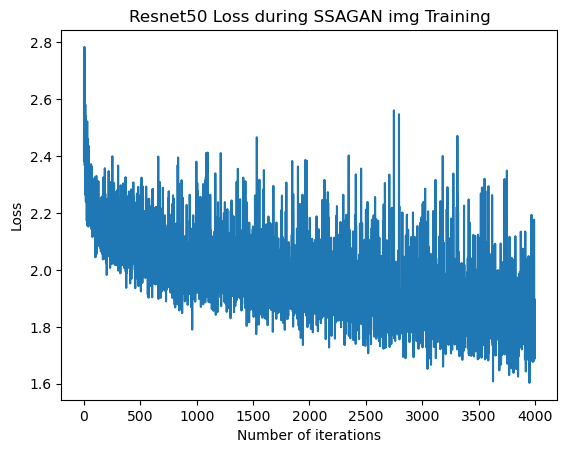

In [55]:
plot_loss(loss_history, "Resnet50 Loss during SSAGAN img Training")

As you can see, the model's loss during training varies wildly, but tends downwards with more epochs. If I had more time, I would love to experiment with different learning rates and a learning rate scheduler, but I don't.

In [59]:
#NOTE: This custom transform class will convert an image from 4 channels "RGBA" to 3 "RGB". 
# I need it since some of the images in my combo foods testing dataset are 4 channels. 
import torch
from torchvision import transforms
from PIL import Image

class ConvertTo3Channels:
    def __call__(self, image: Image.Image):
        if image.mode == 'RGBA':
            # Convert the 4-channel image to a 3-channel image by keeping only RGB channels
            image = image.convert('RGB')
        return image

# Define your other desired transforms
other_transforms = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Combine the custom transform and other transforms using transforms.Compose()
transform_pipeline = transforms.Compose([ConvertTo3Channels()] + other_transforms)


In [60]:
test_combo_dir = "data/test_combo_foods/"
combo_dataset_test = CustomImageDataset(root_dir=test_combo_dir, transform=transform_pipeline)
# Setup Data Loader
batch_size = 25
combo_dataloader_test =  torch.utils.data.DataLoader(combo_dataset_test, batch_size=batch_size,
                                          shuffle=True)

In [47]:
def test(model, testloader, testset, device, loss_fn, test_loss_history):
    model.eval()
    accuracy = 0
    for (data, label) in testloader:
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = loss_fn(out, label)
        test_loss_history.append(loss.item())
        answers = out.max(dim=1)[1]
        accuracy += (answers == label).sum()
    print(f"Total accuracy = {accuracy / len(testset)*100:.2f}%")

Total accuracy = 13.60%


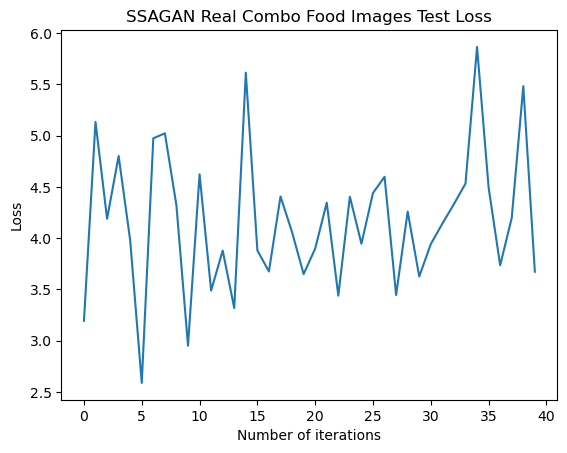

In [61]:
test_loss_history = []
test(model, combo_dataloader_test, combo_dataset_test, device, LossFunction, test_loss_history)
plot_loss(test_loss_history, "SSAGAN Real Combo Food Images Test Loss")

**RESULTS:** I got an accuracy thats a good bit higher than just 10% (see 26% later with Adam Optimizer), so that's at least a partial win! Next, if I had time, I would love to train another Resnet50 with the single images AND the generated combo images, and then see how it does identifying the combo food images. Would it just think they are the single food images? Or would it actually be able to tell between them? If it did, I would consider my project a major success.

TESTING NOTES:
13.6 % accuracy w/ batch_size = 25, SGD Optimizer, lr = 0.0001, for 100 epochs.

## RESULTS PT 2. More Tests w/ Resnet
Now that I have fully implemented my GAN generation to Resnet50 training experiment, I figure I should carry out a couple more tests.

#### More Tests: Resnet50 again, but with ADAM
My loss varied wildly between epochs during my training of the Resnet50, yet it still managed to get 49% accuracy. I wonder if I can improve this accuracy by training it such that it has much less loss variation between epochs. To do this, I will try using ADAM instead of SGD as my learning algorithm, as well as try a couple different learning rates. 

In [69]:
from torchvision import models

num_classes = 10

# Load a pre-trained ResNet-50 resnet_2
resnet_2 = models.resnet50(pretrained=False)

# Replace the last layer with a new fully connected layer for your specific number of classes
resnet_2.fc = torch.nn.Linear(resnet_2.fc.in_features, num_classes)


In [70]:
# Re-initialize the datasets in case we want to test with a different batch size

# Training Dataset Setup
combo_food_dir = "data/combo_foods/"
combo_dataset_train = CustomImageDataset(root_dir=combo_food_dir, transform=transform)
# Setup Data Loader
batch_size = 5 # I just picked 25
combo_dataloader_train =  torch.utils.data.DataLoader(combo_dataset_train, batch_size=batch_size,
                                          shuffle=True)

# Testing Dataset Setup
test_combo_dir = "data/test_combo_foods/"
combo_dataset_test = CustomImageDataset(root_dir=test_combo_dir, transform=transform_pipeline)
# Setup Data Loader
batch_size = 5
combo_dataloader_test =  torch.utils.data.DataLoader(combo_dataset_test, batch_size=batch_size,
                                          shuffle=True)

In [71]:
# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet_2.to(device)
# Let's set up some parameters
learning_rate = 0.0001
nepochs = 100 #its taking forever to train so lets start here


print(resnet_2)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.Adam(resnet_2.parameters(), lr=learning_rate)

# We also need a loss function
LossFunction = torch.nn.CrossEntropyLoss()

# (decided not to copy Steven and reload datasets here - it takes too long)
loss_history = []

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [72]:
train(combo_dataloader_train, resnet_2, LossFunction, optimizer, loss_history, nepochs, device)

Epoch:   1%|          | 1/100 [00:15<25:24, 15.40s/epoch]

Epoch 0: loss: 2.7186391353607178


Epoch:   2%|▏         | 2/100 [00:30<24:24, 14.95s/epoch]

Epoch 1: loss: 1.0466941595077515


Epoch:   3%|▎         | 3/100 [00:44<23:42, 14.67s/epoch]

Epoch 2: loss: 1.2671186923980713


Epoch:   4%|▍         | 4/100 [00:58<23:16, 14.55s/epoch]

Epoch 3: loss: 0.2934933602809906


Epoch:   5%|▌         | 5/100 [01:13<23:01, 14.54s/epoch]

Epoch 4: loss: 0.9968312978744507


Epoch:   6%|▌         | 6/100 [01:27<22:42, 14.50s/epoch]

Epoch 5: loss: 0.4586755335330963


Epoch:   7%|▋         | 7/100 [01:42<22:25, 14.46s/epoch]

Epoch 6: loss: 0.9300905466079712


Epoch:   8%|▊         | 8/100 [01:56<22:12, 14.48s/epoch]

Epoch 7: loss: 0.10555551946163177


Epoch:   9%|▉         | 9/100 [02:11<21:58, 14.48s/epoch]

Epoch 8: loss: 0.014493012800812721


Epoch:  10%|█         | 10/100 [02:25<21:41, 14.46s/epoch]

Epoch 9: loss: 0.881117045879364


Epoch:  11%|█         | 11/100 [02:40<21:31, 14.51s/epoch]

Epoch 10: loss: 0.9107826948165894


Epoch:  12%|█▏        | 12/100 [02:54<21:15, 14.49s/epoch]

Epoch 11: loss: 0.44723400473594666


Epoch:  13%|█▎        | 13/100 [03:09<21:01, 14.50s/epoch]

Epoch 12: loss: 1.546913743019104


Epoch:  14%|█▍        | 14/100 [03:23<20:45, 14.48s/epoch]

Epoch 13: loss: 0.14408865571022034


Epoch:  15%|█▌        | 15/100 [03:37<20:30, 14.48s/epoch]

Epoch 14: loss: 0.0420108288526535


Epoch:  16%|█▌        | 16/100 [03:52<20:16, 14.49s/epoch]

Epoch 15: loss: 0.2615208029747009


Epoch:  17%|█▋        | 17/100 [04:07<20:07, 14.54s/epoch]

Epoch 16: loss: 0.34549856185913086


Epoch:  18%|█▊        | 18/100 [04:21<19:50, 14.52s/epoch]

Epoch 17: loss: 1.1113593578338623


Epoch:  19%|█▉        | 19/100 [04:36<19:33, 14.49s/epoch]

Epoch 18: loss: 0.05071767047047615


Epoch:  20%|██        | 20/100 [04:50<19:21, 14.52s/epoch]

Epoch 19: loss: 0.3013998568058014


Epoch:  21%|██        | 21/100 [05:05<19:07, 14.52s/epoch]

Epoch 20: loss: 0.1511593759059906


Epoch:  22%|██▏       | 22/100 [05:19<18:53, 14.54s/epoch]

Epoch 21: loss: 0.005244101397693157


Epoch:  23%|██▎       | 23/100 [05:34<18:33, 14.46s/epoch]

Epoch 22: loss: 0.026281366124749184


Epoch:  24%|██▍       | 24/100 [05:48<18:17, 14.44s/epoch]

Epoch 23: loss: 0.0015774117782711983


Epoch:  25%|██▌       | 25/100 [06:02<17:59, 14.39s/epoch]

Epoch 24: loss: 0.004926024936139584


Epoch:  26%|██▌       | 26/100 [06:17<17:43, 14.38s/epoch]

Epoch 25: loss: 0.07981051504611969


Epoch:  27%|██▋       | 27/100 [06:31<17:32, 14.42s/epoch]

Epoch 26: loss: 0.3919735252857208


Epoch:  28%|██▊       | 28/100 [06:45<17:16, 14.39s/epoch]

Epoch 27: loss: 0.03081144019961357


Epoch:  29%|██▉       | 29/100 [07:00<17:00, 14.37s/epoch]

Epoch 28: loss: 0.012273273430764675


Epoch:  30%|███       | 30/100 [07:14<16:44, 14.35s/epoch]

Epoch 29: loss: 0.0170724019408226


Epoch:  31%|███       | 31/100 [07:28<16:29, 14.34s/epoch]

Epoch 30: loss: 0.36291441321372986


Epoch:  32%|███▏      | 32/100 [07:43<16:17, 14.37s/epoch]

Epoch 31: loss: 0.0023885315749794245


Epoch:  33%|███▎      | 33/100 [07:57<16:01, 14.35s/epoch]

Epoch 32: loss: 0.002424177946522832


Epoch:  34%|███▍      | 34/100 [08:12<15:50, 14.40s/epoch]

Epoch 33: loss: 0.030555566772818565


Epoch:  35%|███▌      | 35/100 [08:26<15:39, 14.46s/epoch]

Epoch 34: loss: 0.4802342355251312


Epoch:  36%|███▌      | 36/100 [08:41<15:24, 14.44s/epoch]

Epoch 35: loss: 0.42846766114234924


Epoch:  37%|███▋      | 37/100 [08:55<15:09, 14.43s/epoch]

Epoch 36: loss: 0.00018160228501074016


Epoch:  38%|███▊      | 38/100 [09:09<14:55, 14.45s/epoch]

Epoch 37: loss: 0.004714957904070616


Epoch:  39%|███▉      | 39/100 [09:24<14:41, 14.45s/epoch]

Epoch 38: loss: 0.001123995054513216


Epoch:  40%|████      | 40/100 [09:38<14:27, 14.45s/epoch]

Epoch 39: loss: 0.00035960011882707477


Epoch:  41%|████      | 41/100 [09:53<14:11, 14.44s/epoch]

Epoch 40: loss: 0.11659011989831924


Epoch:  42%|████▏     | 42/100 [10:07<14:00, 14.49s/epoch]

Epoch 41: loss: 0.0015378172975033522


Epoch:  43%|████▎     | 43/100 [10:22<13:43, 14.45s/epoch]

Epoch 42: loss: 0.06924937665462494


Epoch:  44%|████▍     | 44/100 [10:36<13:29, 14.46s/epoch]

Epoch 43: loss: 0.02747095562517643


Epoch:  45%|████▌     | 45/100 [10:51<13:14, 14.44s/epoch]

Epoch 44: loss: 0.009814552031457424


Epoch:  46%|████▌     | 46/100 [11:05<13:00, 14.44s/epoch]

Epoch 45: loss: 0.03397701680660248


Epoch:  47%|████▋     | 47/100 [11:20<12:45, 14.45s/epoch]

Epoch 46: loss: 0.02511945739388466


Epoch:  48%|████▊     | 48/100 [11:34<12:30, 14.43s/epoch]

Epoch 47: loss: 0.02254815772175789


Epoch:  49%|████▉     | 49/100 [11:48<12:16, 14.44s/epoch]

Epoch 48: loss: 0.0007229329203255475


Epoch:  50%|█████     | 50/100 [12:03<12:01, 14.43s/epoch]

Epoch 49: loss: 0.15935185551643372


Epoch:  51%|█████     | 51/100 [12:17<11:45, 14.41s/epoch]

Epoch 50: loss: 0.05879266932606697


Epoch:  52%|█████▏    | 52/100 [12:32<11:32, 14.44s/epoch]

Epoch 51: loss: 0.27416273951530457


Epoch:  53%|█████▎    | 53/100 [12:46<11:17, 14.40s/epoch]

Epoch 52: loss: 0.024581681936979294


Epoch:  54%|█████▍    | 54/100 [13:00<11:03, 14.43s/epoch]

Epoch 53: loss: 0.06647300720214844


Epoch:  55%|█████▌    | 55/100 [13:15<10:50, 14.45s/epoch]

Epoch 54: loss: 0.008542438969016075


Epoch:  56%|█████▌    | 56/100 [13:29<10:33, 14.41s/epoch]

Epoch 55: loss: 0.0060537043027579784


Epoch:  57%|█████▋    | 57/100 [13:44<10:17, 14.37s/epoch]

Epoch 56: loss: 0.0004696731921285391


Epoch:  58%|█████▊    | 58/100 [13:58<10:03, 14.37s/epoch]

Epoch 57: loss: 0.0017623389139771461


Epoch:  59%|█████▉    | 59/100 [14:12<09:48, 14.36s/epoch]

Epoch 58: loss: 0.001226212247274816


Epoch:  60%|██████    | 60/100 [14:27<09:35, 14.39s/epoch]

Epoch 59: loss: 0.0002902591659221798


Epoch:  61%|██████    | 61/100 [14:41<09:24, 14.46s/epoch]

Epoch 60: loss: 0.0006021218141540885


Epoch:  62%|██████▏   | 62/100 [14:56<09:10, 14.47s/epoch]

Epoch 61: loss: 0.7206450700759888


Epoch:  63%|██████▎   | 63/100 [15:10<08:56, 14.49s/epoch]

Epoch 62: loss: 0.0019110968569293618


Epoch:  64%|██████▍   | 64/100 [15:25<08:40, 14.47s/epoch]

Epoch 63: loss: 0.22897835075855255


Epoch:  65%|██████▌   | 65/100 [15:39<08:26, 14.46s/epoch]

Epoch 64: loss: 0.0034530963748693466


Epoch:  66%|██████▌   | 66/100 [15:54<08:12, 14.48s/epoch]

Epoch 65: loss: 0.0399559810757637


Epoch:  67%|██████▋   | 67/100 [16:08<07:58, 14.51s/epoch]

Epoch 66: loss: 0.32243096828460693


Epoch:  68%|██████▊   | 68/100 [16:23<07:43, 14.47s/epoch]

Epoch 67: loss: 0.0022879315074533224


Epoch:  69%|██████▉   | 69/100 [16:37<07:28, 14.46s/epoch]

Epoch 68: loss: 0.00086337944958359


Epoch:  70%|███████   | 70/100 [16:52<07:13, 14.43s/epoch]

Epoch 69: loss: 0.0009151551639661193


Epoch:  71%|███████   | 71/100 [17:06<07:00, 14.49s/epoch]

Epoch 70: loss: 0.0003237986529711634


Epoch:  72%|███████▏  | 72/100 [17:21<06:45, 14.49s/epoch]

Epoch 71: loss: 0.004530339501798153


Epoch:  73%|███████▎  | 73/100 [17:35<06:30, 14.46s/epoch]

Epoch 72: loss: 0.00024255136668216437


Epoch:  74%|███████▍  | 74/100 [17:50<06:16, 14.46s/epoch]

Epoch 73: loss: 0.0008090976625680923


Epoch:  75%|███████▌  | 75/100 [18:04<06:02, 14.48s/epoch]

Epoch 74: loss: 0.029235119000077248


Epoch:  76%|███████▌  | 76/100 [18:18<05:47, 14.47s/epoch]

Epoch 75: loss: 0.022803882136940956


Epoch:  77%|███████▋  | 77/100 [18:33<05:32, 14.46s/epoch]

Epoch 76: loss: 0.0013114444445818663


Epoch:  78%|███████▊  | 78/100 [18:47<05:18, 14.46s/epoch]

Epoch 77: loss: 4.257958062225953e-05


Epoch:  79%|███████▉  | 79/100 [19:02<05:03, 14.46s/epoch]

Epoch 78: loss: 0.005627835635095835


Epoch:  80%|████████  | 80/100 [19:16<04:49, 14.49s/epoch]

Epoch 79: loss: 1.1133955922559835e-05


Epoch:  81%|████████  | 81/100 [19:31<04:34, 14.42s/epoch]

Epoch 80: loss: 0.0002460206742398441


Epoch:  82%|████████▏ | 82/100 [19:45<04:19, 14.39s/epoch]

Epoch 81: loss: 0.0016501048812642694


Epoch:  83%|████████▎ | 83/100 [19:59<04:04, 14.41s/epoch]

Epoch 82: loss: 0.007269324269145727


Epoch:  84%|████████▍ | 84/100 [20:14<03:51, 14.45s/epoch]

Epoch 83: loss: 0.007839640602469444


Epoch:  85%|████████▌ | 85/100 [20:28<03:36, 14.44s/epoch]

Epoch 84: loss: 0.0007180253742262721


Epoch:  86%|████████▌ | 86/100 [20:43<03:22, 14.44s/epoch]

Epoch 85: loss: 1.9788003555731848e-05


Epoch:  87%|████████▋ | 87/100 [20:57<03:07, 14.45s/epoch]

Epoch 86: loss: 0.027295727282762527


Epoch:  88%|████████▊ | 88/100 [21:12<02:53, 14.46s/epoch]

Epoch 87: loss: 0.001842177240177989


Epoch:  89%|████████▉ | 89/100 [21:26<02:39, 14.46s/epoch]

Epoch 88: loss: 0.0342719629406929


Epoch:  90%|█████████ | 90/100 [21:41<02:24, 14.46s/epoch]

Epoch 89: loss: 0.0028804237954318523


Epoch:  91%|█████████ | 91/100 [21:55<02:09, 14.44s/epoch]

Epoch 90: loss: 0.0008985018357634544


Epoch:  92%|█████████▏| 92/100 [22:10<01:55, 14.45s/epoch]

Epoch 91: loss: 8.39228778204415e-06


Epoch:  93%|█████████▎| 93/100 [22:24<01:41, 14.46s/epoch]

Epoch 92: loss: 0.0011027883738279343


Epoch:  94%|█████████▍| 94/100 [22:38<01:26, 14.45s/epoch]

Epoch 93: loss: 0.0010848497040569782


Epoch:  95%|█████████▌| 95/100 [22:53<01:12, 14.43s/epoch]

Epoch 94: loss: 0.0037562388461083174


Epoch:  96%|█████████▌| 96/100 [23:07<00:57, 14.47s/epoch]

Epoch 95: loss: 0.008013024926185608


Epoch:  97%|█████████▋| 97/100 [23:22<00:43, 14.44s/epoch]

Epoch 96: loss: 4.758583236252889e-05


Epoch:  98%|█████████▊| 98/100 [23:36<00:28, 14.44s/epoch]

Epoch 97: loss: 0.000769364123698324


Epoch:  99%|█████████▉| 99/100 [23:51<00:14, 14.43s/epoch]

Epoch 98: loss: 2.815625339280814e-05


Epoch: 100%|██████████| 100/100 [24:05<00:00, 14.46s/epoch]

Epoch 99: loss: 8.891802281141281e-05


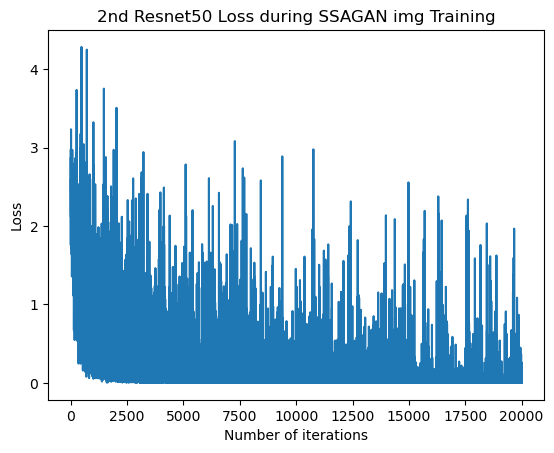

In [73]:
plot_loss(loss_history, "2nd Resnet50 Loss during SSAGAN img Training")

In [17]:
def test(model, testloader, testset, device, loss_fn, test_loss_history):
    model.eval()
    accuracy = 0
    for (data, label) in testloader:
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = loss_fn(out, label)
        test_loss_history.append(loss.item())
        answers = out.max(dim=1)[1]
        accuracy += (answers == label).sum()
    print(f"Total accuracy = {accuracy / len(testset)*100:.2f}%")

Total accuracy = 22.00%


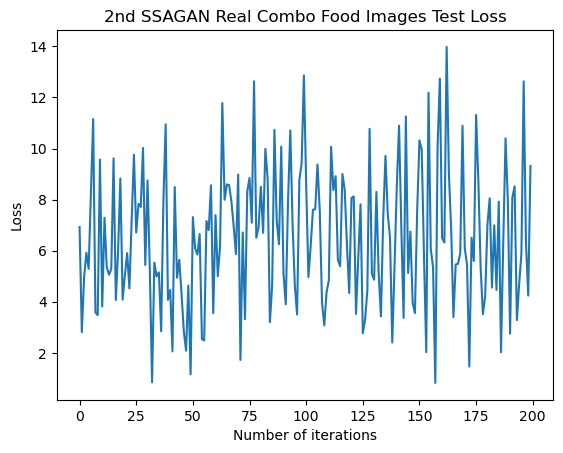

In [74]:
test_loss_history = []
test(resnet_2, combo_dataloader_test, combo_dataset_test, device, LossFunction, test_loss_history)
plot_loss(test_loss_history, "2nd SSAGAN Real Combo Food Images Test Loss")

In [75]:
# This code was generated by ChatGPT
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    
    # Initialize confusion matrix and other counters
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update confusion matrix
            cm += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=np.arange(num_classes))
    
    # Calculate total accuracy
    total_accuracy = correct / total
    
    # Calculate accuracy per class
    per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
    
    return total_accuracy, per_class_accuracy

# Assuming your test dataloader is named 'test_dataloader'
num_classes = 10
total_accuracy, per_class_accuracy = evaluate_model(resnet_2, combo_dataloader_test, device, num_classes)

print("Total accuracy:", total_accuracy)
print("Per-class accuracy:", per_class_accuracy)


Total accuracy: 0.22
Per-class accuracy: [0.04 0.   0.23 0.3  0.45 0.38 0.12 0.37 0.1  0.21]


#### TESTING NOTES:
1. 26.30 % accuracy w/ batch_size = 10, ADAM Optimizer, lr = 0.0001, for 100 epochs.
2. 23.20 % accuracy w/ batch_size = 25, ADAM Optimizer, lr = 0.0001, for 100 epochs.
2. 22.00 % accuracy w/ batch_size = 5, ADAM Optimizer, lr = 0.0001, for 100 epochs.

#### TESTING ANALYSIS
26% Accuracy is good enough for me to consider my project a success, because it shows that the Resnet50 can learn to identify real images of combination foods from the generated ones. There is still a lot of room for improvement, as shown by the fact that changing my Resnet50 opitimizer from SGD to Adam increased its accuracy from 13% to 26%, however I don't want to spend a lot of time tuning parameters. There is also a lot more image generation I could do, considering how I was able to generate 1000 images in about a minute. I think I could easily improve my generated image dataset by providing more captions, which is cool because it is similar to how a human could better learn about something they have never seen before by reading more about it.

#### DEBUG SECTION - Getting error from combo images test dataset, verifying its images with the following scripts.

In [34]:
import os
from PIL import Image

def check_images_in_folder(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except Exception as e:
                    print(f"Error processing image {file_path}: {e}")

folder_path = "data/test_combo_foods/"
check_images_in_folder(folder_path)

In [33]:
import imghdr

def check_image_formats_in_folder(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img_format = imghdr.what(file_path)
                if img_format not in ('jpeg', 'jpg'):
                    print(f"Image {file_path} has an incorrect format: {img_format}")

folder_path = "data/test_combo_foods/"
check_image_formats_in_folder(folder_path)